### 天池智慧海洋

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm,tqdm_notebook
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn import metrics
import warnings

warnings.filterwarnings('ignore')
train_path = './input/train'
test_path = './input/test'
# os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
train_file = os.listdir(train_path)
test_file = os.listdir(test_path)

In [2]:
print(len(train_file),len(test_file))
print(train_file[:5])
print(test_file[:5])

7000 2000
['0.csv', '1.csv', '10.csv', '100.csv', '1000.csv']
['7000.csv', '7001.csv', '7002.csv', '7003.csv', '7004.csv']


In [3]:
# f-string在形式上是以f修饰字符串（f'xxx'）,用{}标明被替换的字段
df = pd.read_csv(f'{train_path}/1234.csv')
df.head()

,渔船ID,x,y,速度,方向,time,type
0,1234,6.735123e+06,6.568010e+06,0.22,0,1120 23:55:37,围网
1,1234,6.735123e+06,6.568010e+06,0.11,30,1120 23:45:39,围网
2,1234,6.735123e+06,6.568010e+06,0.11,339,1120 23:35:35,围网
3,1234,6.735212e+06,6.568014e+06,0.11,136,1120 23:15:32,围网
4,1234,6.735212e+06,6.568014e+06,0.22,132,1120 23:05:33,围网


In [4]:
df.type.unique()

array(['围网'], dtype=object)

In [5]:
df.shape

(414, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
渔船ID    414 non-null int64
x       414 non-null float64
y       414 non-null float64
速度      414 non-null float64
方向      414 non-null int64
time    414 non-null object
type    414 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 22.7+ KB


In [7]:
df.describe()

,渔船ID,x,y,速度,方向
count,414.0,4.140000e+02,4.140000e+02,414.000000,414.000000
mean,1234.0,6.608138e+06,6.581958e+06,1.138188,102.876812
std,0.0,4.705685e+04,4.674156e+03,2.702052,112.674451
min,1234.0,6.587116e+06,6.567792e+06,0.000000,0.000000
25%,1234.0,6.587210e+06,6.583972e+06,0.110000,0.000000
50%,1234.0,6.587210e+06,6.583972e+06,0.110000,81.000000
75%,1234.0,6.587299e+06,6.583972e+06,0.220000,165.250000
max,1234.0,6.735310e+06,6.584560e+06,10.090000,359.000000


In [8]:
# 读取所有训练文件的所有数据
res = []
for file in tqdm(train_file):
    df = pd.read_csv(f'{train_path}/{file}')
    res.append(df)
df = pd.concat(res)
df.columns = ['ship','x','y','v','d','time','type']
print(df.shape)
# hdf形成的h5文件拥有更快的读写速度,远高于csv
df.to_hdf('./input/train.h5','df',mode='w')

# 读取测试文件
res = []
for file in tqdm(test_file):
    df = pd.read_csv(f'{test_path}/{file}')
    res.append(df)
df = pd.concat(res)
df.columns = ['ship','x','y','v','d','time']
print(df.shape)
df.to_hdf('./input/test.h5','df',mode='w')

100%|█████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:51<00:00, 135.57it/s]


(2699638, 7)


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.06it/s]


(782378, 6)


In [9]:
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)

In [10]:
train = pd.read_hdf('./input/train.h5')
t = train[train['ship']==1234]
t.head()

,ship,x,y,v,d,time,type
0,1234,6.735123e+06,6.568010e+06,0.22,0,1120 23:55:37,围网
1,1234,6.735123e+06,6.568010e+06,0.11,30,1120 23:45:39,围网
2,1234,6.735123e+06,6.568010e+06,0.11,339,1120 23:35:35,围网
3,1234,6.735212e+06,6.568014e+06,0.11,136,1120 23:15:32,围网
4,1234,6.735212e+06,6.568014e+06,0.22,132,1120 23:05:33,围网


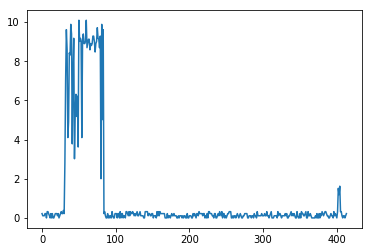

In [11]:
plt.plot(t['v'])

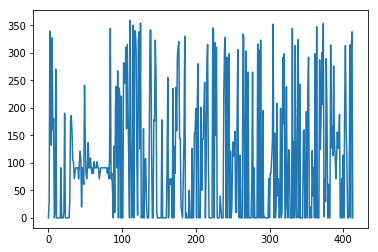

In [12]:
plt.plot(t['d'])

In [13]:
# 展示三种不同渔船的经纬度图像
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

In [14]:
train[train['ship']==2963].head()

,ship,x,y,v,d,time,type
0,2963,6.315982e+06,5.291346e+06,0.0,0,1120 23:57:26,围网
1,2963,6.315982e+06,5.291346e+06,0.0,0,1120 23:47:26,围网
2,2963,6.315982e+06,5.291346e+06,0.0,0,1120 23:37:26,围网
3,2963,6.315982e+06,5.291346e+06,0.0,0,1120 23:27:26,围网
4,2963,6.315982e+06,5.291346e+06,0.0,0,1120 23:17:26,围网


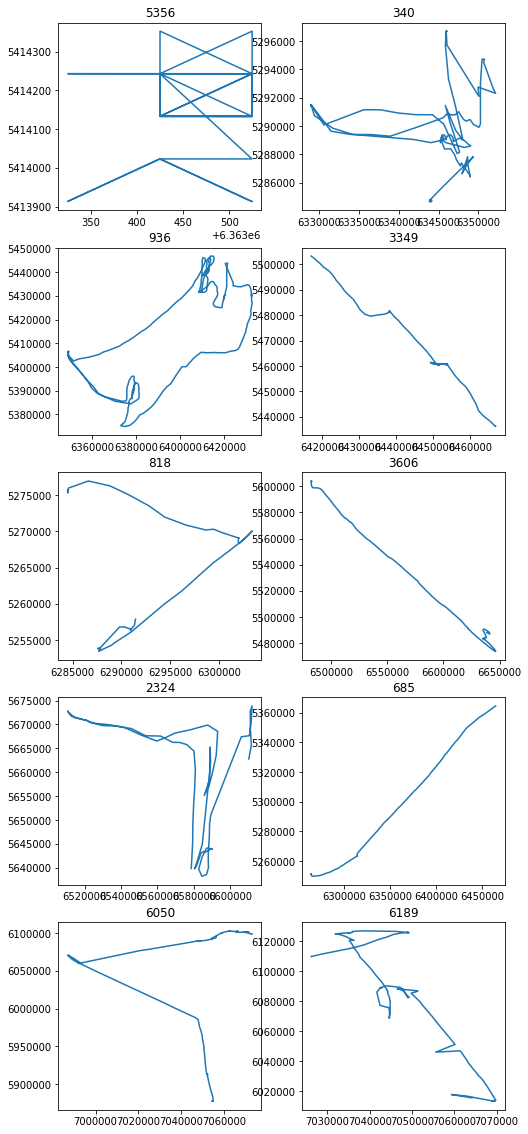

In [15]:
show_path('围网')

In [16]:
train[train['ship']==4022].head()

,ship,x,y,v,d,time,type
0,4022,6.102550e+06,5.112648e+06,0.0,0,1120 23:55:45,拖网
1,4022,6.102550e+06,5.112648e+06,0.0,0,1120 23:45:45,拖网
2,4022,6.102550e+06,5.112648e+06,0.0,0,1120 23:35:45,拖网
3,4022,6.102550e+06,5.112648e+06,0.0,0,1120 23:25:45,拖网
4,4022,6.102550e+06,5.112648e+06,0.0,0,1120 23:15:45,拖网


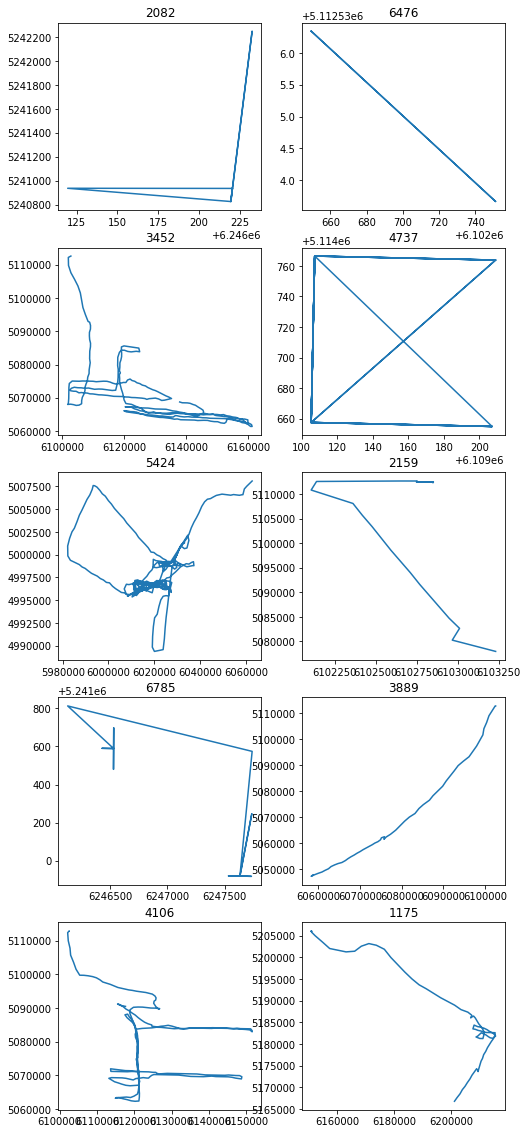

In [17]:
show_path('拖网')

In [18]:
train[train['ship']==1415].head()

,ship,x,y,v,d,time,type
0,1415,6.346640e+06,5.336511e+06,0.22,102,1110 11:54:35,刺网
1,1415,6.346640e+06,5.336511e+06,0.11,0,1110 11:44:35,刺网
2,1415,6.346640e+06,5.336511e+06,0.11,0,1110 11:34:35,刺网
3,1415,6.345538e+06,5.336624e+06,2.70,5,1110 11:24:33,刺网
4,1415,6.345538e+06,5.336514e+06,0.49,0,1110 11:14:32,刺网


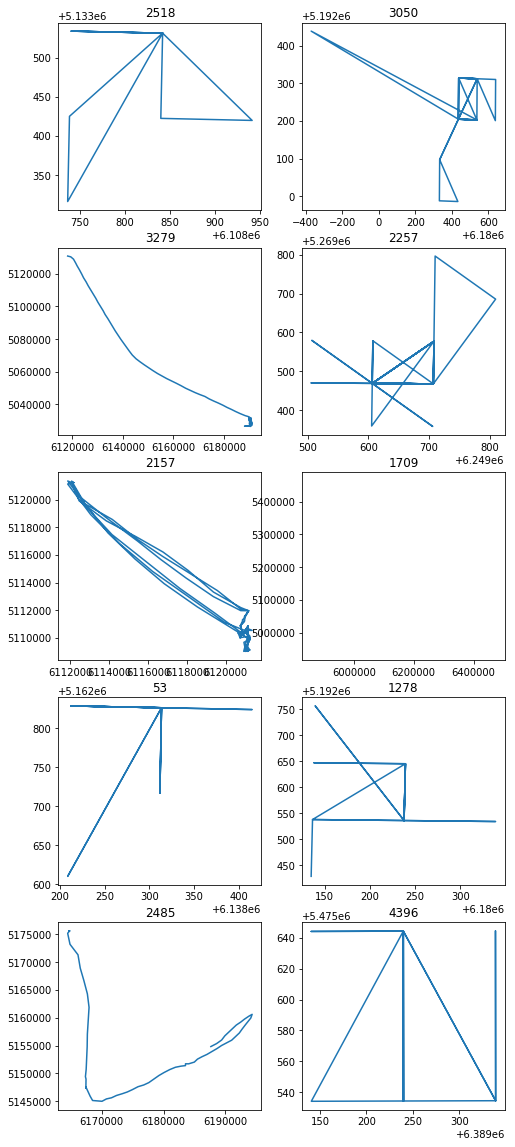

In [19]:
show_path('刺网')

In [29]:
# 特征工程
def group_feature(df,key,target,aggs):
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag
    print(agg_dict)
    # 以key进行分组,选择特定的特征提取其函数结果作为新特征,函数包含在字典中
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
    return t

def extract_feature(df,train):
    # ship指船号,对每一艘船的x,y,v,d的数据的特征进行提取
    t = group_feature(df, 'ship','x',['max','min','mean','std','skew','sum','count',
                                      'median','mad'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','y',['max','min','mean','std','skew','sum','count',
                                      'median','mad'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','v',['max','min','mean','std','skew','sum','count'])
    train = pd.merge(train, t, on='ship', how='left')
    t = group_feature(df, 'ship','d',['max','min','mean','std','skew','sum','count'])
    train = pd.merge(train, t, on='ship', how='left')
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    train['y_max_over_x_min'] = train['y_max'] / train['x_min']
    train['slope'] = train['y_max_y_min'] / np.where(train['x_max_x_min']==0, 0.001, train['x_max_x_min'])
    train['area'] = train['x_max_x_min'] * train['y_max_y_min']
    
    # mode_hour特征是指船号对应的出现频率最大的hour
    mode_hour = df.groupby('ship')['hour'].agg(lambda x:x.value_counts().index[0]).to_dict()
    # 用map将船号改为船号对应的mode_hour特征
    train['mode_hour'] = train['ship'].map(mode_hour)
    
    # 提取hour的函数特征
    t = group_feature(df, 'ship','hour',['max','min'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # 提取hour和date的独特数量的特征
    hour_nunique = df.groupby('ship')['hour'].nunique().to_dict()
    date_nunique = df.groupby('ship')['date'].nunique().to_dict()
    train['hour_nunique'] = train['ship'].map(hour_nunique)
    train['date_nunique'] = train['ship'].map(date_nunique)
    
    # 提取时间差特征,时间数据的形式缩写为dt
    t = df.groupby('ship')['time'].agg({'diff_time':lambda x:np.max(x)-np.min(x)}).reset_index()
    t['diff_day'] = t['diff_time'].dt.days
    t['diff_second'] = t['diff_time'].dt.seconds
    train = pd.merge(train, t, on='ship', how='left')
    return train

# 时间特征处理
def extract_dt(df):
    df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    # df['month'] = df['time'].dt.month
    # df['day'] = df['time'].dt.day
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    # df = df.drop_duplicates(['ship','month'])
    df['weekday'] = df['time'].dt.weekday
    return df

In [22]:
# 正式加载数据并提取时间特征
train = pd.read_hdf('./input/train.h5')
test = pd.read_hdf('./input/test.h5')

train = extract_dt(train)
test = extract_dt(test)

In [23]:
# 每艘船都有很多数据,针对不同(x,y,v,d)提取的特征都是单个值,所以需要去重操作
train_label = train.drop_duplicates('ship')
test_label = test.drop_duplicates('ship')

In [24]:
# value_counts()第一个参数是normalize,输入1或者true返回元素频率
train_label['type'].value_counts(1)

拖网    0.623000
围网    0.231571
刺网    0.145429
Name: type, dtype: float64

In [25]:
# 将预测变量改为数值形式
type_map = dict(zip(train_label['type'].unique(),np.arange(3)))
type_map_rev = {v:k for k,v in type_map.items()}
train_label['type'] = train_label['type'].map(type_map)

In [30]:
# 提取所有特征
train_label = extract_feature(train,train_label)
test_label = extract_feature(test,test_label)

{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum', 'x_count': 'count', 'x_median': 'median', 'x_mad': 'mad'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum', 'y_count': 'count', 'y_median': 'median', 'y_mad': 'mad'}
{'v_max': 'max', 'v_min': 'min', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew', 'v_sum': 'sum', 'v_count': 'count'}
{'d_max': 'max', 'd_min': 'min', 'd_mean': 'mean', 'd_std': 'std', 'd_skew': 'skew', 'd_sum': 'sum', 'd_count': 'count'}
{'hour_max': 'max', 'hour_min': 'min'}
{'x_max': 'max', 'x_min': 'min', 'x_mean': 'mean', 'x_std': 'std', 'x_skew': 'skew', 'x_sum': 'sum', 'x_count': 'count', 'x_median': 'median', 'x_mad': 'mad'}
{'y_max': 'max', 'y_min': 'min', 'y_mean': 'mean', 'y_std': 'std', 'y_skew': 'skew', 'y_sum': 'sum', 'y_count': 'count', 'y_median': 'median', 'y_mad': 'mad'}
{'v_max': 'max', 'v_min': 'min', 'v_mean': 'mean', 'v_std': 'std', 'v_skew': 'skew'

In [31]:
train_label.head()

,ship,x,y,v,d,time,type,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,x_median,x_mad,y_max,y_min,y_mean,y_std,y_skew,y_sum,y_count,y_median,y_mad,v_max,v_min,v_mean,v_std,v_skew,v_sum,v_count,d_max,d_min,d_mean,d_std,d_skew,d_sum,d_count,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,y_max_over_x_min,slope,area,mode_hour,hour_max,hour_min,hour_nunique,date_nunique,diff_time,diff_day,diff_second
0,0,6.152038e+06,5.124873e+06,2.59,102,1900-11-10 11:58:19,0,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,6.118352e+06,1905.724573,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,414,5.130672e+06,341.078408,9.39,0.0,0.265966,1.321248,5.520205,110.11,414,129,0,4.613527,21.247770,4.483093,1910,414,33686.667453,5907.975523,-9.875704e+05,1.027165e+06,0.838589,0.175380,1.990200e+08,15,23,0,24,4,2 days 23:48:51,2,85731
1,1,6.076254e+06,5.061743e+06,3.99,278,1900-11-10 11:40:21,0,1900-11-10,11,5,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,385,6.102450e+06,14574.134228,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,385,5.112760e+06,24712.754023,10.47,0.0,1.607922,2.412688,1.590284,619.05,385,336,0,56.153247,91.449382,1.418867,21619,385,52978.013345,70016.655842,-9.365979e+05,1.059593e+06,0.845177,1.321617,3.709343e+09,19,23,0,24,4,2 days 23:39:47,2,85187
2,10,6.321032e+06,5.242805e+06,4.48,213,1900-11-10 11:49:36,0,1900-11-10,11,5,6.346913e+06,6.246119e+06,6.262484e+06,32280.567149,1.623040,2.486206e+09,397,6.246120e+06,25318.018154,5.265810e+06,5.229867e+06,5.242458e+06,5975.460236,2.198003,2.081256e+09,397,5.240937e+06,3556.709015,10.09,0.0,1.313854,2.442825,2.145410,521.60,397,359,0,108.758186,112.515081,0.727645,43177,397,100794.674835,35942.703641,-9.803087e+05,1.117046e+06,0.843053,0.356593,3.622833e+09,23,23,0,24,4,2 days 23:33:53,2,84833
3,100,6.102751e+06,5.112534e+06,0.00,0,1900-10-30 23:50:05,0,1900-10-30,23,1,6.151439e+06,6.102326e+06,6.123711e+06,14451.941954,0.021860,2.516845e+09,411,6.123431e+06,12392.343016,5.112752e+06,5.069616e+06,5.085480e+06,14020.260117,1.055676,2.090132e+09,411,5.082056e+06,10839.543586,8.69,0.0,2.965864,1.647069,-0.215287,1218.97,411,353,0,161.727494,115.409256,-0.020073,66470,411,49113.022232,43135.705758,-9.895740e+05,1.081823e+06,0.837837,0.878295,2.118525e+09,11,23,0,24,3,2 days 23:48:47,2,85727
4,1000,6.843713e+06,5.480538e+06,2.00,216,1900-11-06 23:42:30,1,1900-11-06,23,1,6.844414e+06,6.748890e+06,6.807536e+06,26263.537565,-0.770190,2.566441e+09,377,6.809206e+06,18041.318374,5.540087e+06,5.440815e+06,5.464764e+06,30135.645906,1.412544,2.060216e+09,377,5.450299e+06,23649.086501,8.90,0.0,2.085570,2.649306,1.110173,786.26,377,358,0,159.143236,101.832626,0.217397,59997,377,95524.035775,99271.486171,-1.208803e+06,1.403598e+06,0.820889,1.039230,9.482813e+09,0,23,0,24,3,2 days 23:37:11,2,85031


In [32]:
feats = [i for i in train_label.columns if i not in ['ship','type','time','diff_time','date']]
target = 'type'

In [33]:
X = train_label[feats].copy()
y = train_label[target]

In [42]:
# 五折交叉验证
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# 准备预测
models = []
pred = np.zeros((len(test_label),3))
oof = np.zeros((len(X),3))

In [43]:
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
}

In [44]:
# 根据y进行层次性划分数据集
for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):

    train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
    val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])

    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100)
    models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = np.argmax(val_pred, axis=1)
    print(index, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))

    test_pred = model.predict(test_label[feats])
    pred += test_pred/5

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0742488	valid_1's multi_logloss: 0.256387
[200]	training's multi_logloss: 0.0179983	valid_1's multi_logloss: 0.250474
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0446609	valid_1's multi_logloss: 0.248783
0 val f1 0.8830722752211361
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0739873	valid_1's multi_logloss: 0.266106
[200]	training's multi_logloss: 0.0173781	valid_1's multi_logloss: 0.251418
[300]	training's multi_logloss: 0.00443185	valid_1's multi_logloss: 0.264997
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.0155919	valid_1's multi_logloss: 0.251061
1 val f1 0.8810952139878054
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0750938	valid_1's multi_logloss: 0.277659
[200]	training's multi_logloss: 0.0185033	valid_1's multi_logloss: 0.273061


In [45]:
# 返回最大下标的索引,即是对应的类型
oof = np.argmax(oof, axis=1)
print('oof f1', metrics.f1_score(oof, y, average='macro'))

oof f1 0.8761191391615434


In [46]:
# 创建提交文件
pred = np.argmax(pred, axis=1)
sub = test_label[['ship']]
sub['pred'] = pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
sub.to_csv('./output/result.csv', index=None, header=None)

0    0.6325
1    0.2360
2    0.1315
Name: pred, dtype: float64


In [47]:
# 查看特征重要性
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)

In [48]:
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)
df

,name,score
24,v_std,591.8
42,y_max,564.6
43,y_max_over_x_min,560.0
35,x_min,545.8
32,x_max_y_min,539.8
23,v_skew,494.8
34,x_median,479.4
44,y_max_x_min,478.0
36,x_skew,450.8
47,y_median,447.8
